<a href="https://colab.research.google.com/github/dornercr/INFO371/blob/main/INFO371_legalcase_NB_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔧 Initializing components...
✅ SpaCy, Faker, and stemmer ready.
📦 Generating 10,000 legal case summaries...
✅ Dataset created.
🔠 Vectorizing text using CountVectorizer + custom tokenizer...


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


✅ Vectorization complete. Feature matrix shape: (10000, 793)
📚 Splitting data: 80% train, 20% test...
✅ Split complete.
🧠 Training Naive Bayes model...
✅ Model trained.
🔁 Running cross-validation...

📈 Cross-Validation Scores: [1. 1. 1. 1. 1.]
📊 Mean CV Accuracy: 1.0

🔍 Predicting test set...
✅ Prediction complete.

🧾 Evaluation on Test Set:
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0

📊 Confusion Matrix:


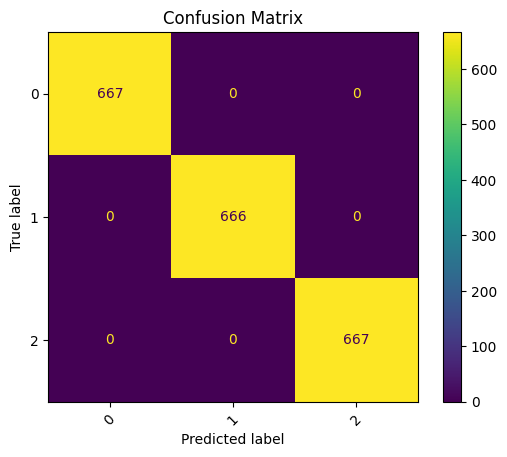


📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       667
           1       1.00      1.00      1.00       666
           2       1.00      1.00      1.00       667

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


🔎 Top predictive words per class:

Top words for class '0':
  breach          -> log-prob: -3.3200
  right           -> log-prob: -3.9497
  properti        -> log-prob: -3.9539
  disput          -> log-prob: -3.9771
  intellectu      -> log-prob: -3.9771
  fiduciari       -> log-prob: -3.9879
  alleg           -> log-prob: -3.9879
  duti            -> log-prob: -3.9879
  action          -> log-prob: -3.9966
  class           -> log-prob: -4.0054

Top words for class '1':
  charg           -> log-prob: -3.2581
  condit          -> log-prob: -3.9275
  degre           -> log-prob: -3.9339

In [5]:
import pandas as pd
import numpy as np
import random
from faker import Faker
import spacy
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
import matplotlib.pyplot as plt

# Setup
print("🔧 Initializing components...")
fake = Faker()
nlp = spacy.load("en_core_web_sm")
stemmer = PorterStemmer()
random.seed(42)
print("✅ SpaCy, Faker, and stemmer ready.")

# Class labels
categories = ["Criminal", "Civil", "Family Law"]

# Generate synthetic legal case summaries
def generate_case(label):
    criminal = [
        "The defendant was charged with armed robbery", "Investigation revealed drug trafficking activities",
        "Assault and battery occurred at the victim’s residence", "Suspect violated parole conditions",
        "Felony burglary charges were filed", "Accused of second-degree murder"
    ]
    civil = [
        "Plaintiff filed a breach of contract claim", "Defendant denied liability in tort case",
        "Class-action lawsuit regarding faulty appliances", "Tenant sued landlord over unsafe conditions",
        "Breach of fiduciary duty was alleged", "Dispute over intellectual property rights"
    ]
    family = [
        "Petitioner filed for custody of the minor children", "Divorce proceedings initiated due to irreconcilable differences",
        "Court reviewed alimony payments", "Modification of child support requested",
        "Domestic partnership dissolution filed", "Adoption finalized in court hearing"
    ]
    noise = fake.sentence()

    if label == "Criminal":
        return f"{random.choice(criminal)}. {noise}"
    elif label == "Civil":
        return f"{random.choice(civil)}. {noise}"
    else:
        return f"{random.choice(family)}. {noise}"

print("📦 Generating 10,000 legal case summaries...")
comments = []
labels = []
for _ in range(3333):
    comments.append(generate_case("Criminal"))
    labels.append("Criminal")
for _ in range(3333):
    comments.append(generate_case("Civil"))
    labels.append("Civil")
for _ in range(3334):
    comments.append(generate_case("Family Law"))
    labels.append("Family Law")

df = pd.DataFrame({"Comment": comments, "Topic": labels})
print("✅ Dataset created.")

# Tokenizer
def spacy_tokenizer(sentence):
    doc = nlp(str(sentence))
    return [stemmer.stem(token.lemma_.lower().strip()) for token in doc if not token.is_stop and token.is_alpha]

# Vectorize
print("🔠 Vectorizing text using CountVectorizer + custom tokenizer...")
vectorizer = CountVectorizer(tokenizer=spacy_tokenizer, ngram_range=(1,1))
X = vectorizer.fit_transform(df['Comment'])
y = df['Topic'].astype('category').cat.codes
print(f"✅ Vectorization complete. Feature matrix shape: {X.shape}")

# Train-test split
print("📚 Splitting data: 80% train, 20% test...")
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print("✅ Split complete.")

# Train model
print("🧠 Training Naive Bayes model...")
clf = MultinomialNB()
clf.fit(X_train, y_train)
print("✅ Model trained.")

# Cross-validation
print("🔁 Running cross-validation...")
cv_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy')
print("\n📈 Cross-Validation Scores:", cv_scores)
print("📊 Mean CV Accuracy:", round(np.mean(cv_scores), 4))

# Predict
print("\n🔍 Predicting test set...")
preds = clf.predict(X_test)
print("✅ Prediction complete.")

# Evaluate
print("\n🧾 Evaluation on Test Set:")
print("Precision:", round(precision_score(y_test, preds, average='weighted'), 4))
print("Recall:", round(recall_score(y_test, preds, average='weighted'), 4))
print("F1 Score:", round(f1_score(y_test, preds, average='weighted'), 4))
print("Accuracy:", round(accuracy_score(y_test, preds), 4))

# Confusion matrix
print("\n📊 Confusion Matrix:")
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# Classification report
print("\n📋 Classification Report:")
target_names = [str(cls) for cls in clf.classes_]
print(classification_report(y_test, preds, target_names=target_names))

# Top predictive words per class
print("\n🔎 Top predictive words per class:")
feature_names = vectorizer.get_feature_names_out()
for i, class_label in enumerate(clf.classes_):
    top10 = np.argsort(clf.feature_log_prob_[i])[-10:]
    print(f"\nTop words for class '{class_label}':")
    for j in top10[::-1]:
        print(f"  {feature_names[j]:<15} -> log-prob: {clf.feature_log_prob_[i][j]:.4f}")
